In [ ]:
# Configuration
BATCH_SIZE = 64
LR = 0.0002       # Standard GAN learning rate
EPOCHS = 300      # Sufficient for this data size
LATENT_DIM = 5    

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os

df = pd.read_csv("data.csv", encoding='latin1')
df.head()

C:\Users\vansh\AppData\Local\Temp\ipykernel_17940\681147169.py:11: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data.csv", encoding='latin1')


,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Running on: cpu


In [4]:
# Only No2
x = pd.to_numeric(df['no2'], errors='coerce').dropna()
x = x[x >= 0].values

# roll number
r = 102483084

# Transformation
ar = 0.5 * (r % 7)
br = 0.3 * ((r % 5) + 1)
z = x + ar * np.sin(br * x)
z = z.reshape(-1, 1)

# Normalization
scaler = StandardScaler()
z_norm = scaler.fit_transform(z)

z_tensor = torch.FloatTensor(z_norm).to(device)
dataloader = torch.utils.data.DataLoader(z_tensor, batch_size=64, shuffle=True)

GAN Architecture

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(LATENT_DIM, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1)
        )
    def forward(self, x): return self.net(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, x): return self.net(x)

# Init
gen = Generator().to(device)
disc = Discriminator().to(device)
opt_g = optim.Adam(gen.parameters(), lr=LR)
opt_d = optim.Adam(disc.parameters(), lr=LR)
criterion = nn.BCELoss()

In [8]:
print("Training...")
for epoch in range(EPOCHS):
    for real in dataloader:
        batch = real.size(0)
        real_label = torch.ones(batch, 1).to(device)
        fake_label = torch.zeros(batch, 1).to(device)
        
        # Train Discriminator
        opt_d.zero_grad()
        output_real = disc(real)
        loss_real = criterion(output_real, real_label)
        
        noise = torch.randn(batch, LATENT_DIM).to(device)
        fake = gen(noise)
        output_fake = disc(fake.detach())
        loss_fake = criterion(output_fake, fake_label)
        
        loss_d = loss_real + loss_fake
        loss_d.backward()
        opt_d.step()
        
        # Train Generator
        opt_g.zero_grad()
        output_fake_g = disc(fake)
        loss_g = criterion(output_fake_g, real_label)
        loss_g.backward()
        opt_g.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}: D_loss={loss_d.item():.4f} G_loss={loss_g.item():.4f}")

Training...
Epoch 0: D_loss=1.3823 G_loss=0.7029
Epoch 50: D_loss=1.3896 G_loss=0.6931
Epoch 100: D_loss=1.3879 G_loss=0.6928
Epoch 150: D_loss=1.3870 G_loss=0.6933
Epoch 200: D_loss=1.3855 G_loss=0.6939
Epoch 250: D_loss=1.3849 G_loss=0.6968


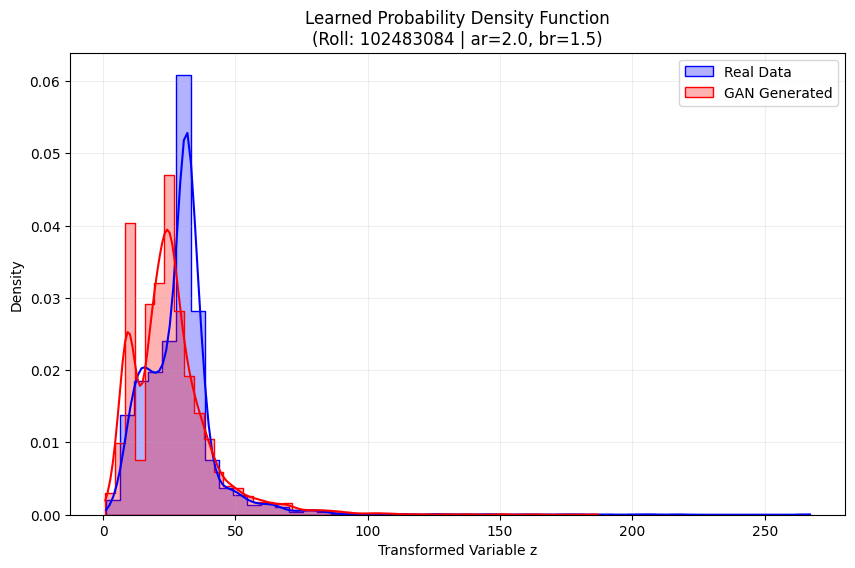

In [9]:
gen.cpu()
with torch.no_grad():
    fake_scaled = gen(torch.randn(5000, LATENT_DIM)).numpy()
    
fake_data = scaler.inverse_transform(fake_scaled)
real_data_subset = z[:5000]

plt.figure(figsize=(10, 6))
# Histogram + KDE
sns.histplot(real_data_subset.flatten(), bins=50, stat='density', kde=True, 
             label='Real Data', color='blue', alpha=0.3, element="step")
sns.histplot(fake_data.flatten(), bins=50, stat='density', kde=True, 
             label='GAN Generated', color='red', alpha=0.3, element="step")

plt.title(f"Learned Probability Density Function\n(Roll: 102483084 | ar={ar}, br={br})")
plt.xlabel("Transformed Variable z")
plt.legend()
plt.grid(True, alpha=0.2)
plt.savefig("gan_pdf_result.png")
plt.show()